<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Семинар 5: PyTorch Lightning и подбор гиперпараметров
Преподаватель: Иван Карпухин, ведущий программист-исследователь команды машинного зрения Mail.ru Group

<div style="clear:both;"></div>

План:
* Обучение моделей при помощи PyTorch Lightning
* Конфигурирование систем
* Подбор гиперпараметров при помощи Optuna

Для работы необходимы следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision
* pytorch_lightning
* optuna

In [1]:
import numpy as np
import optuna
import pytorch_lightning as pl
import torch
import torchvision

from matplotlib import pyplot as plt

from seminar import make_grid

USE_CUDA = torch.cuda.is_available()
CUDA_DEVICES = [0]

BATCHSIZE = 64
EPOCHS = 5

DATA_ROOT = "data"
TRAIN_ROOT = "train"

print("PyTorch version: {}".format(torch.__version__))
print("Use CUDA: {}".format(USE_CUDA))

PyTorch version: 1.7.1
Use CUDA: True


### Типичный ML pipeline

<img src="resources/bicycle.jpg" width="35%" height="35%" align="left">
<div style="clear:both;"></div>

Большое количество кода повторяется от проекта к проекту:
* Тренировочный цикл
* Управление чекпоинтами
* Работа с GPU и распределённая тренировка

Типичные пайплайны уже реализованы в высокоуровневых библиотеках:
* TensorFlow Estimator
* PyTorch Ignite
* PyTorch Lightning

См. сравнение Ignite и Lightning:

https://towardsdatascience.com/pytorch-lightning-vs-pytorch-ignite-vs-fast-ai-61dc7480ad8a

### Pytorch Lightning

<img src="resources/lightning.png" align="left">
<div style="clear:both;"></div>

# Тренировка с Pytorch Lightning

Создадим три базовых класса: LightningDataModule, LightningModule, Trainer.

### LightningDataModule

* Хранит информацию о Train/Dev/Test корпусах
* Создаёт DataLoader-ы

Если нужно несколько корупсов:

https://pytorch-lightning.readthedocs.io/en/stable/multiple_loaders.html

Files already downloaded and verified
Files already downloaded and verified
train size: 50000


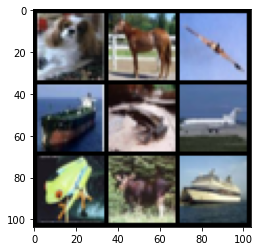

dev size: 5000


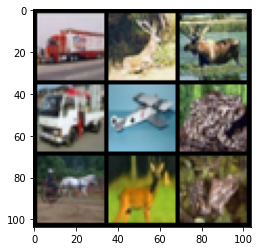

test size: 5000


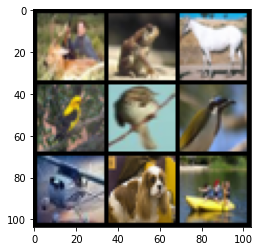

In [2]:
class DataModule(pl.LightningDataModule):
    """Handles Train/Dev/Test sets and data loading."""
    def __init__(self, data_root, batch_size):
        super().__init__()
        self._data_root = data_root

        self._labels = ["airplane", "automobile", "bird", "cat", "deer",
                        "dog", "frog", "horse", "ship", "truck"]

        self._loader_params = {
            "pin_memory": True if USE_CUDA else False,
            "batch_size": batch_size,
            "num_workers": 1  # Prepare data in parallel.
        }

    @property
    def num_classes(self):
        return len(self._labels)

    @property
    def labels(self):
        return self._labels

    def setup(self, stage=None):
        transform = torchvision.transforms.ToTensor()
        kwargs = {
            "download": True,
            "transform": transform
        }
        trainset = torchvision.datasets.CIFAR10(self._data_root,
                                                train=True,
                                                download=True,
                                                transform=transform)
        devtestset = torchvision.datasets.CIFAR10(self._data_root,
                                                  train=False,
                                                  download=True,
                                                  transform=transform)

        length = len(devtestset) // 2
        generator = torch.Generator().manual_seed(42)
        devset, testset = torch.utils.data.random_split(devtestset,
                                                        [length, length],
                                                        generator=generator)
        self._datasets = {
            "train": trainset,
            "dev": devset,
            "test": testset
        }

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["train"],
                                           **self._loader_params)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["dev"],
                                           **self._loader_params)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["test"],
                                           **self._loader_params)

    def show(self, tag="train"):
        dataset = self._datasets[tag]
        print("{} size: {}".format(tag, len(dataset)))
        samples = [
            dataset[i][0] for i in np.random.choice(range(len(dataset)), 9)
        ]
        plt.imshow(torchvision.utils.make_grid(samples, nrow=3).permute(1, 2, 0))
        plt.show()


data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
data.setup()

for tag in ["train", "dev", "test"]:
    data.show(tag)

### LightningModule

Объединяет:
* Модель
* Loss
* Оптимизатор

In [3]:
class Module(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self._model = torchvision.models.resnet18(num_classes=num_classes,
                                                  pretrained=False)
        self._loss = torch.nn.CrossEntropyLoss()

    @property
    def model(self):
        return self._model

    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        self.log("TrainLoss", loss)
        return loss

### Trainer

Реализует пайплайн обучения. Наследовать не нужно.

In [4]:
data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
module = Module(num_classes=data.num_classes)

trainer = pl.Trainer(
    default_root_dir=TRAIN_ROOT,
    gpus=0 if not USE_CUDA else CUDA_DEVICES,
    max_epochs=2
)
trainer.fit(module, data)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/home/alexander/miniconda3/envs/2_base_dl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
/home/alexander/miniconda3/envs/2_base_dl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

1

Запустить tensorboard server:
```bash
tensorboard --logdir ./train
```

Для Google Colab:
```bash
%load_ext tensorboard
%tensorboard --logdir ./train
```

По умолчанию сервер запустится на 6006 порту.

<img src="resources/board-1-simple.png" align="left">
<div style="clear:both;"></div>

# Extra logs

* Добавим логгирование Dev loss.
* Tensorboard обновляется каждые 2 минуты. Уменьшим этот период до 10 секунд.
* Логируется каждый 50-й батч. Увеличим до 100.
* Добавим в Tensorboard изображения с предсказаниями.

In [5]:
class Module(pl.LightningModule):
    def __init__(self, num_classes, labels):
        super().__init__()
        self._labels = labels
        self._model = torchvision.models.resnet18(num_classes=num_classes,
                                                  pretrained=False)
        self._loss = torch.nn.CrossEntropyLoss()

    @property
    def model(self):
        return self._model

    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        loss = self._compute_loss(batch)
        if self.global_step % 100 == 0:  # NEW.
            # Train curve will be plotted on the common Loss plot.
            self.logger.experiment.add_scalars("Loss", {"train": loss},
                                               global_step=self.global_step)
        if self.global_step % 500 == 0:  # NEW.
            # Show predicted images.
            self._plot(batch)
        return loss

    # NEW CODE BELOW. 
    def validation_step(self, batch, batch_idx):
        """Process single batch during validation."""
        return self._compute_loss(batch)

    def validation_epoch_end(self, losses):
        """Accumulate and log validation losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"dev": loss},
                                           global_step=self.global_step)

    def test_step(self, batch, batch_idx):
        """Process single batch during testing."""
        return self._compute_loss(batch)

    def test_epoch_end(self, losses):
        """Accumulate and log test losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"test": loss},
                                           global_step=self.global_step)

    def _compute_loss(self, batch):
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        return loss

    def _plot(self, batch, size=9):
        predictions = self._model(batch[0]).argmax(1)
        grid = make_grid(batch[0], predictions, self._labels)
        # Add image to TensorBoard.
        self.logger.experiment.add_image("Predictions", grid,
                                         global_step=self.global_step)

data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
module = Module(num_classes=data.num_classes, labels=data.labels)

# Train dir will have the following structure:
# root
#   - experiment
#      - version
#         - checkpoints
#         - <logs>

logger = pl.loggers.TensorBoardLogger(
    save_dir=TRAIN_ROOT,  # Root for all experiments.
    name="extra_logs",  # Experiment name, same as subdirectory name.
    # version=0,  #  You can choose specific experiment version.
    flush_secs=10  # Update TensorBoard every 10 seconds.
)

trainer = pl.Trainer(
    logger=logger,
    gpus=0 if not USE_CUDA else CUDA_DEVICES,
    max_epochs=2
)

trainer.fit(module, data)
trainer.test()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
/home/alexander/miniconda3/envs/2_base_dl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


/home/alexander/miniconda3/envs/2_base_dl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

<img src="resources/board-2-plot.png" align="left">
<div style="clear:both;"></div>

### More options
* Train using 2 GPUs
* Train in FP16

In [7]:
logger = pl.loggers.TensorBoardLogger(
    save_dir=TRAIN_ROOT,  # Root for all experiments.
    name="fp16",  # Experiment name, same as subdirectory name.
    # version=0,  #  You can choose specific experiment version.
    flush_secs=10  # Update TensorBoard every 10 seconds.
)

trainer = pl.Trainer(
    logger=logger,
    gpus=0 if not USE_CUDA else CUDA_DEVICES,  # [0, 1] for two GPUs.
    distributed_backend="dp",  # "ddp" is better but doesn't work in Jupyter.
    precision=16,
    progress_bar_refresh_rate=20,
    max_epochs=EPOCHS
)

trainer.fit(module, data)
trainer.test()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

<img src="resources/gpu-usage.png" align="left">
<div style="clear:both;"></div>

<img src="resources/board-3-fp16.png" align="left">
<div style="clear:both;"></div>

# Конфигурация систем

### Плоский конфиг

In [8]:
class Head(torch.nn.Sequential):
    def __init__(self, input_size, output_size, bottleneck_size):
        super().__init__(
            torch.nn.Linear(input_size, bottleneck_size),
            torch.nn.ReLU(),
            torch.nn.Linear(bottleneck_size, output_size)
        )

class Model(torch.nn.Module):
    def __init__(self, input_size, bottleneck_size,
                 head1_bottleneck_size, head1_output_size,
                 head2_bottleneck_size, head2_output_size):
        super().__init__()
        self._stem = torch.nn.Linear(input_size, bottleneck_size)
        self._head1 = Head(bottleneck_size,
                           head1_output_size,
                           head1_bottleneck_size)
        self._head2 = Head(bottleneck_size,
                           head2_output_size,
                           head2_bottleneck_size)

    def forward(self, batch):
        embeddings = self._stem(batch)
        output1 = self._head1(embeddings)
        output2 = self._head2(embeddings)
        return output1, output2

config = {
    "bottleneck_size": 512,
    "head1_output_size": 128,
    "head1_bottleneck_size": 256,
    "head2_output_size": 64,
    "head2_bottleneck_size": 256
}

Model(
    input_size=128,
    bottleneck_size=config["bottleneck_size"],
    head1_output_size=config["head1_output_size"],
    head1_bottleneck_size=config["head1_bottleneck_size"],
    head2_output_size=config["head2_output_size"],
    head2_bottleneck_size=config["head2_bottleneck_size"]
)

Model(
  (_stem): Linear(in_features=128, out_features=512, bias=True)
  (_head1): Head(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (_head2): Head(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)


Плюсы:

<span style="color:green">
    
* самый популярный вариант;
* самый простой и понятный.
</span>

Минусы:

<span style="color:red">
    
* высокоуровневые классы разрастаются при появлении новых опций;
* конфиг должен хранить все параметры и устаревает при появлении новых;
* высокоуровневые классы сильно связаны с реализации вложенных.
    
</span>

In [9]:
help(torchvision.models.detection.FasterRCNN.__init__)

Help on function __init__ in module torchvision.models.detection.faster_rcnn:

__init__(self, backbone, num_classes=None, min_size=800, max_size=1333, image_mean=None, image_std=None, rpn_anchor_generator=None, rpn_head=None, rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000, rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000, rpn_nms_thresh=0.7, rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3, rpn_batch_size_per_image=256, rpn_positive_fraction=0.5, box_roi_pool=None, box_head=None, box_predictor=None, box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100, box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5, box_batch_size_per_image=512, box_positive_fraction=0.25, bbox_reg_weights=None)
    Initializes internal Module state, shared by both nn.Module and ScriptModule.



### Иерархический конфиг

In [10]:
class Head(torch.nn.Sequential):
    def __init__(self, input_size, config):
        super().__init__(
            torch.nn.Linear(input_size, config["bottleneck_size"]),
            torch.nn.ReLU(),
            torch.nn.Linear(config["bottleneck_size"], config["output_size"])
        )
        self._config = config

    @property
    def output_size(self):
        return self._config["output_size"]


class Model(torch.nn.Module):
    def __init__(self, input_size, config):
        super().__init__()
        self._stem = torch.nn.Linear(input_size, config["bottleneck_size"])
        self._head1 = Head(config["bottleneck_size"],
                           config=config["head1_params"])
        self._head2 = Head(config["bottleneck_size"],
                           config=config["head2_params"])

    @property
    def output_size(self):
        return (self._head1.output_size, self._head2.output_size)

    def forward(self, batch):
        embeddings = self._stem(batch)
        output1 = self._head1(embeddings)
        output2 = self._head2(embeddings)
        return output1, output2


config = {
    "bottleneck_size": 512,
    "head1_params": {
        "bottleneck_size": 128,
        "output_size": 128
    },
    "head2_params": {
        "bottleneck_size": 128,
        "output_size": 64
    }
}

Model(128, config=config)

Model(
  (_stem): Linear(in_features=128, out_features=512, bias=True)
  (_head1): Head(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (_head2): Head(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
)

### Иерархический конфиг с параметрами по умолчанию

In [11]:
from collections import OrderedDict
from config import prepare_config, ConfigError

class Configurable:
    @staticmethod
    def get_default_config():
        return {
            "a": 5,
            "b": 8
        }

obj = Configurable()

In [12]:
prepare_config(obj)

OrderedDict([('a', 5), ('b', 8)])

In [13]:
prepare_config(obj, config={"a": 10})

OrderedDict([('a', 10), ('b', 8)])

In [14]:
try:
    prepare_config(obj, config={"c": 5})
except ConfigError as e:
    print("EXCEPTION:", e)

EXCEPTION: Unknown parameter c


Применим ирархические конфиги к нашей модели:
* добавим значения по умолчанию;
* добавим выбор функции активации во вложенном классе.

In [15]:
class Head(torch.nn.Sequential):
    ACTIVATIONS = {
        "relu": torch.nn.ReLU,
        "tanh": torch.nn.Tanh
    }

    @staticmethod
    def get_default_config(bottleneck_size=256,
                           output_size=128,
                           activation="relu"):
        """Get head config.

        Args:
            bottleneck_size: ...
            output_size: ...
            activation: ...
        """
        return OrderedDict([
            ("bottleneck_size", bottleneck_size),
            ("output_size", output_size),
            ("activation", activation)
        ])

    def __init__(self, input_size, config=None):
        config = prepare_config(self, config)
        super().__init__(
            torch.nn.Linear(input_size, config["bottleneck_size"]),
            self.ACTIVATIONS[config["activation"]](),
            torch.nn.Linear(config["bottleneck_size"], config["output_size"])
        )
        self._config = config

    @property
    def output_size(self):
        return self._config["output_size"]


class Model(torch.nn.Module):
    @staticmethod
    def get_default_config(bottleneck_size=512,
                           head1_params=None,
                           head2_params=None):
        """Get model config.

        Args:
            head1_params: ...
            head2_params: ...
        """
        return OrderedDict([
            ("bottleneck_size", bottleneck_size),
            ("head1_params", head1_params),
            ("head2_params", head2_params)
        ])

    def __init__(self, input_size, config=None):
        super().__init__()
        config = prepare_config(self, config)
        self._stem = torch.nn.Linear(input_size, config["bottleneck_size"])
        self._head1 = Head(config["bottleneck_size"],
                           config=config["head1_params"])
        self._head2 = Head(config["bottleneck_size"],
                           config=config["head2_params"])

    @property
    def output_size(self):
        return (self._head1.output_size, self._head2.output_size)

    def forward(self, batch):
        embeddings = self._stem(batch)
        output1 = self._head1(embeddings)
        output2 = self._head2(embeddings)
        return output1, output2


config = {
    "head1_params": {
        "activation": "tanh"
    },
    "head2_params": {
        "bottleneck_size": 64
    }
}

Model(128, config=config)

Model(
  (_stem): Linear(in_features=128, out_features=512, bias=True)
  (_head1): Head(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (_head2): Head(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
  )
)

Фрагмент реального конфига:

In [16]:
{
    "feature_dim": 13,
    "backbone_params": {
        "cnn_params": {
            "channels": [32, 64, 128, 256],
            "kernel": [1, 3],
            "stride": [1, 1],
            "activation": "lrelu_inplace",
            "pooling": None,
            "normalization": "instance"
        },
        "rnn_params": {
            "units": [256],
            "bidirectional": True,
            "normalization": "layer"
        },
        "fc_params": {
            "units": [256, 256, 63],
            "normalization": "layer",
            "activation": "relu_inplace"
        },
        "no_head_labels": ["base_label"],
        "labels": ["base_label", "label1", "label2"],
        "cnn_features_as_channels": True
    },
    "output_label": "label1",
    "model": "crnn_gmm",
    "head_params": {
        "n_components": 3,
        "scale": 0.01,
        "feature_dim": 10
    },
    "selector": "max_weight",
    "selector_params": {
        "ignore_components": [2]
    }
}
None

Плюсы:

<span style="color:green">

* параметризация изолирована в каждом классе;
* при добавлении новых параметров старые конфиги не устаревают, если значения по умолчанию воспроизводят старую логику;
* автоматически проверяется правильность конфига (отсутствие лишних параметров).
</span>

Минусы:

<span style="color:red">

* бывает сложно найти соответствующий параметру класс (в плоском конфиге можно дать развернутое имя: generator_lr вместо lr).

</span>

# Подбор гиперпараметров при помощи Optuna

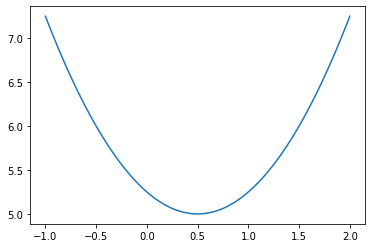

In [17]:
loss = lambda x, y: (x - 0.5) ** 2 + y * 0.01 + 5

xs = np.linspace(-1, 2, 100)
plt.plot(xs, loss(xs, xs * 0))
plt.show()

In [18]:
def experiment(trial):
    x = trial.suggest_float("x", -10, 10)
    y = trial.suggest_float("y", -10, 10)
    return loss(x, y)

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study()
study.optimize(experiment, n_trials=50, n_jobs=5)

optuna.logging.set_verbosity(optuna.logging.INFO)

print("Value:", study.best_value)
print("Parameters:", study.best_params)
print("Importance:", optuna.importance.get_param_importances(study))

Value: 4.917781063552336
Parameters: {'x': 0.5751188808919603, 'y': -8.786178271412515}
Importance: OrderedDict([('x', 0.9816806409636851), ('y', 0.01831935903631485)])


# Конфиги и гиперпараметры

Метод prepare_config умеет парсить гиперпараметры. Для этого нужен контекст suggest_config.

In [19]:
from collections import OrderedDict
from config import prepare_config, suggest_config, ConfigError

class Configurable:
    @staticmethod
    def get_default_config():
        return {
            "num_layers": 16
        }

def experiment(trial):
    config = {
        "_hyper": {
            "num_layers": {
                "type": "int",
                "low": 16,
                "high": 32,
                "step": 8
            }
        },
        "num_layers": 5
    }
    with suggest_config(trial):
        print(prepare_config(Configurable(), config))
    return np.random.random()

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study()
study.optimize(experiment, n_trials=5)

optuna.logging.set_verbosity(optuna.logging.INFO)

OrderedDict([('num_layers', 16)])
OrderedDict([('num_layers', 24)])
OrderedDict([('num_layers', 24)])
OrderedDict([('num_layers', 32)])
OrderedDict([('num_layers', 24)])


### Конфигурируемый Optimizer

In [20]:
from collections import OrderedDict
from config import prepare_config, suggest_config, ConfigError

class AdamOptimizer(torch.optim.Adam):
    @staticmethod
    def get_default_config(lr=1e-3, beta1=0.9, beta2=0.999,
                           weight_decay=0, amsgrad=False):
        return OrderedDict([
            ("lr", lr),
            ("beta1", beta1),
            ("beta2", beta2),
            ("weight_decay", weight_decay),
            ("amsgrad", amsgrad)
        ])

    def __init__(self, params, config=None):
        config = prepare_config(self, config)
        super().__init__(params,
                         lr=config["lr"],
                         betas=(config["beta1"], config["beta2"]),
                         weight_decay=config["weight_decay"],
                         amsgrad=config["amsgrad"])


class SGDOptimizer(torch.optim.SGD):
    @staticmethod
    def get_default_config(lr=1e-3, momentum=0, weight_decay=0, nesterov=False):
        return OrderedDict([
            ("lr", lr),
            ("momentum", momentum),
            ("weight_decay", weight_decay),
            ("nesterov", nesterov)
        ])

    def __init__(self, params, config=None):
        config = prepare_config(self, config)
        super().__init__(params,
                         lr=config["lr"],
                         momentum=config["momentum"],
                         weight_decay=config["weight_decay"],
                         nesterov=config["nesterov"])


class Optimizer(torch.optim.Optimizer):
    OPTIMIZERS = {
        "adam": AdamOptimizer,
        "sgd": SGDOptimizer
    }

    @staticmethod
    def get_default_config(optimizer="adam", optimizer_params=None):
        return OrderedDict([
            ("optimizer", optimizer),
            ("optimizer_params", optimizer_params)
        ])

    def __init__(self, params, config=None):
        # No super().__init__. Inheritance is only for PyTorch Lightning checks.
        self._config = prepare_config(self, config)
        self._optimizer = self.OPTIMIZERS[self._config["optimizer"]](
            params, self._config["optimizer_params"]
        )

    def step(self, closure=None):
        kwargs = {}
        if closure is not None:
            kwargs["closure"] = closure
        self._optimizer.step(**kwargs)

    def zero_grad(self):
        self._optimizer.zero_grad()

    def state_dict(self):
        return self._optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self._optimizer.load_state_dict(state_dict)

    @property
    def param_groups(self):
        return self._optimizer.param_groups

    @property
    def state(self):
        return self._optimizer.state

### Конфигурируемый DataModule

In [21]:
class DataModule(pl.LightningDataModule):
    """Handles Train/Dev/Test sets and data loading."""

    @staticmethod
    def get_default_config(batch_size=64):
        return OrderedDict([
            ("batch_size", batch_size)
        ])

    def __init__(self, data_root, config=None):
        super().__init__()
        config = prepare_config(self, config)
        self._data_root = data_root

        self._labels = ["airplane", "automobile", "bird", "cat", "deer",
                        "dog", "frog", "horse", "ship", "truck"]

        self._loader_params = {
            "pin_memory": True if USE_CUDA else False,
            "batch_size": config["batch_size"],
            "num_workers": 1  # Prepare data in parallel.
        }

    @property
    def num_classes(self):
        return len(self._labels)

    @property
    def labels(self):
        return self._labels

    def setup(self, stage=None):
        transform = torchvision.transforms.ToTensor()
        kwargs = {
            "download": True,
            "transform": transform
        }
        trainset = torchvision.datasets.CIFAR10(self._data_root,
                                                train=True,
                                                download=True,
                                                transform=transform)
        devtestset = torchvision.datasets.CIFAR10(self._data_root,
                                                  train=False,
                                                  download=True,
                                                  transform=transform)

        length = len(devtestset) // 2
        generator = torch.Generator().manual_seed(42)
        devset, testset = torch.utils.data.random_split(devtestset,
                                                        [length, length],
                                                        generator=generator)
        self._datasets = {
            "train": trainset,
            "dev": devset,
            "test": testset
        }

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["train"],
                                           **self._loader_params)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["dev"],
                                           **self._loader_params)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["test"],
                                           **self._loader_params)

    def show(self, tag="train"):
        dataset = self._datasets[tag]
        print("{} size: {}".format(tag, len(dataset)))
        samples = [
            dataset[i][0] for i in np.random.choice(range(len(dataset)), 9)
        ]
        plt.imshow(torchvision.utils.make_grid(samples, nrow=3).permute(1, 2, 0))
        plt.show()

### Конфигурируемый Module

In [22]:
class Module(pl.LightningModule):
    MODELS = {
        "resnet18": torchvision.models.resnet18,
        "resnet34": torchvision.models.resnet34
    }

    @staticmethod
    def get_default_config(model="resnet18", optimizer_params=None):
        return OrderedDict([
            ("model", model),
            ("optimizer_params", optimizer_params)
        ])

    def __init__(self, num_classes, labels, config=None):
        super().__init__()
        self._config = prepare_config(self, config)
        self._labels = labels
        self._model = self.MODELS[self._config["model"]](
            num_classes=num_classes, pretrained=False
        )
        self._loss = torch.nn.CrossEntropyLoss()

    @property
    def model(self):
        return self._model

    def configure_optimizers(self):
        return Optimizer(self._model.parameters(),
                         config=self._config["optimizer_params"])

    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        loss = self._compute_loss(batch)
        if self.global_step % 100 == 0:
            # Train curve will be plotted on the common Loss plot.
            self.logger.experiment.add_scalars("Loss", {"train": loss},
                                               global_step=self.global_step)
        if self.global_step % 500 == 0:
            self._plot(batch)
        return loss

    def validation_step(self, batch, batch_idx):
        """Process single batch during validation."""
        return self._compute_loss(batch)

    def validation_epoch_end(self, losses):
        """Accumulate and log validation losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"dev": loss},
                                           global_step=self.global_step)
        # Return validation loss for early stopping.
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        """Process single batch during testing."""
        return self._compute_loss(batch)

    def test_epoch_end(self, losses):
        """Accumulate and log test losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"test": loss},
                                           global_step=self.global_step)

    def _compute_loss(self, batch):
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        return loss

    def _plot(self, batch, size=9):
        predictions = self._model(batch[0]).argmax(1)
        grid = make_grid(batch[0], predictions, self._labels)
        # Add image to TensorBoard.
        self.logger.experiment.add_image("Predictions", grid,
                                         global_step=self.global_step)

### Объединим всё в одну систему

In [23]:
class Experiment:
    @staticmethod
    def get_default_config(data_params=None, module_params=None,
                           use_fp16=False):
        return OrderedDict([
            ("seed", 42),
            ("data_params", data_params),
            ("module_params", module_params),
            ("use_fp16", use_fp16)
        ])

    def __init__(self, train_root, config=None):
        self._train_root = train_root
        self._config = config

    def __call__(self, trial):
        with suggest_config(trial):
            config = prepare_config(self, self._config)

            torch.manual_seed(config["seed"])
            np.random.seed(config["seed"])

            data = DataModule(DATA_ROOT, config=config["data_params"])
            module = Module(data.num_classes, data.labels,
                            config=config["module_params"])

            logger = pl.loggers.TensorBoardLogger(
                save_dir=self._train_root,  # Root for all experiments.
                name="hyper",  # Experiment name, same as subdirectory name.
                flush_secs=10  # Update TensorBoard every 10 seconds.
            )

            trainer = pl.Trainer(
                logger=logger,
                gpus=0 if not USE_CUDA else CUDA_DEVICES,
                # "ddp" is better but it doesn't work in Jupyter:
                distributed_backend="dp",
                precision=16 if config["use_fp16"] else 32,
                max_epochs=EPOCHS,

                # Optuna callback for early stopping.
                callbacks=[optuna.integration.PyTorchLightningPruningCallback(
                    trial, monitor="val_loss"
                )]
            )

            trainer.fit(module, data)
        return trainer.callback_metrics["val_loss"].item()

import os
os.makedirs(TRAIN_ROOT, exist_ok=True)
study = optuna.create_study("sqlite:///{}/study.db".format(TRAIN_ROOT))

config = {
    "_hyper": {
        "seed": {"type": "int", "low": 0, "high": 10}
    },
    "data_params": {
        "_hyper": {
            "batch_size": {"type": "int", "low": 64, "high": 512, "step": 64}
        }
    },
    "module_params": {
        "_hyper": {
            "model": {"choices": ["resnet18", "resnet34"]}
        },
        "optimizer_params": {
            "_hyper": {
                "optimizer": {
                    "choices": ["adam", "sgd"]
                }
            },
            "optimizer_params": {
                "_hyper": {
                    "lr": {"type": "float", "low": 1e-5, "high": 1e-2},
                    "amsgrad": {"choices": [True, False]},
                    "nesterov": {"choices": [True, False]},
                    "weight_decay": {"type": "float", "low": 0, "high": 1e-4},
                    "momentum": {"type": "float", "low": 0, "high": 1}
                }
            }
        }
    }
}

study.optimize(Experiment(TRAIN_ROOT, config=config), n_trials=2)
result = {
    "value": study.best_value,
    "params": study.best_params,
    "importance": optuna.importance.get_param_importances(study)
}

import json
with open(os.path.join(TRAIN_ROOT, "result.json"), "w") as fp:
    json.dump(result, fp)

print(result)

[I 2021-02-18 08:34:15,820] A new study created in RDB with name: no-name-205e6cb5-6e6e-46b6-b12d-a95e3da38f27
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21.3 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule



[I 2021-02-18 08:36:20,171] Trial 0 finished with value: 1.9052765369415283 and parameters: {'seed': 1, 'data_params.batch_size': 512, 'module_params.model': 'resnet34', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.002792494367510301, 'module_params.optimizer_params.optimizer_params.amsgrad': False, 'module_params.optimizer_params.optimizer_params.weight_decay': 5.125088032180162e-05}. Best is trial 0 with value: 1.9052765369415283.


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule



[I 2021-02-18 08:37:52,657] Trial 1 finished with value: 1.5972238779067993 and parameters: {'seed': 6, 'data_params.batch_size': 512, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'sgd', 'module_params.optimizer_params.optimizer_params.lr': 0.008327274985148132, 'module_params.optimizer_params.optimizer_params.nesterov': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 5.032197453135412e-05, 'module_params.optimizer_params.optimizer_params.momentum': 0.11735459175731577}. Best is trial 1 with value: 1.5972238779067993.



{'value': 1.5972238779067993, 'params': {'data_params.batch_size': 512, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'sgd', 'module_params.optimizer_params.optimizer_params.lr': 0.008327274985148132, 'module_params.optimizer_params.optimizer_params.momentum': 0.11735459175731577, 'module_params.optimizer_params.optimizer_params.nesterov': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 5.032197453135412e-05, 'seed': 6}, 'importance': OrderedDict([('module_params.optimizer_params.optimizer', 0.28125), ('module_params.model', 0.28125), ('module_params.optimizer_params.optimizer_params.lr', 0.25), ('module_params.optimizer_params.optimizer_params.weight_decay', 0.125), ('seed', 0.0625), ('data_params.batch_size', 0.0)])}


<img src="resources/board-4-hyper.png" align="left">
<div style="clear:both;"></div>

In [24]:
print("Best parameters:")
print("")
for k, v in result["params"].items():
    print(k)
    print("    ", v)

Best parameters:

data_params.batch_size
     512
module_params.model
     resnet18
module_params.optimizer_params.optimizer
     sgd
module_params.optimizer_params.optimizer_params.lr
     0.008327274985148132
module_params.optimizer_params.optimizer_params.momentum
     0.11735459175731577
module_params.optimizer_params.optimizer_params.nesterov
     True
module_params.optimizer_params.optimizer_params.weight_decay
     5.032197453135412e-05
seed
     6


In [25]:
print("Importance:")
print("")
for k, v in result["importance"].items():
    print("{:.3f}".format(v), k)

Importance:

0.281 module_params.optimizer_params.optimizer
0.281 module_params.model
0.250 module_params.optimizer_params.optimizer_params.lr
0.125 module_params.optimizer_params.optimizer_params.weight_decay
0.062 seed
0.000 data_params.batch_size


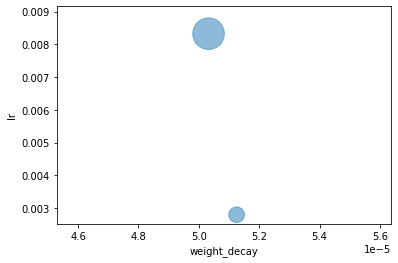

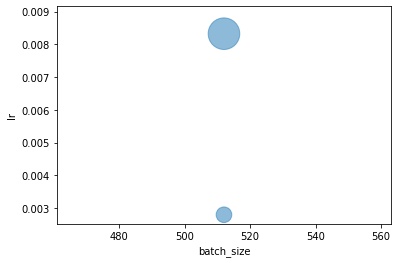

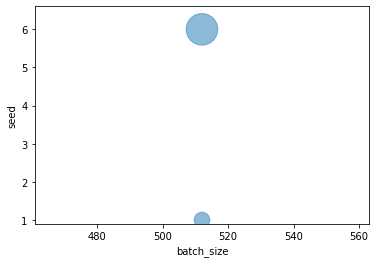

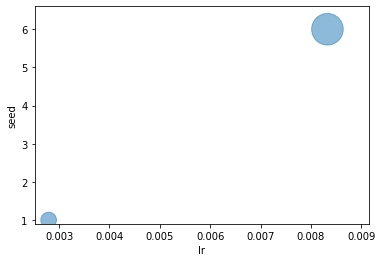

In [26]:
import os
from seminar import show_study

show_study(os.path.join(TRAIN_ROOT, "study.db"))

Дальнейшие действия:
* посмотреть на реализацию `prepare_config` и `suggest_config`;
* сделать параметр `pretrained` модели конфигурируемым и запустить подбор гиперпараметров;
* попробовать сделать параметрические FC и Conv слои, подобрать их параметры (например, размер свёртки) на CIFAR10;
* cтандартный `pruner` из Optuna останавливает тренировку экспериментов, если на первых итерациях модель остаёт от медианы. Попробовать улучшить качество, подобрав `pruner` и параметры.